# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
# !pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os # Dùng làm việc với các đường dẫn dệ dàng hơn 
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 5

In [3]:
os.getcwd()

'd:\\NCKH\\FaceDetection'

In [5]:
cap = cv2.VideoCapture(0)
for img_num in range(number_images):
    print('Collecting image {}'.format(img_num))
    ret, frame = cap.read()
    imgName = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgName, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [6]:
!labelme

Traceback (most recent call last):
  File "D:\anaconda3\envs\FaceDetection\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\anaconda3\envs\FaceDetection\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "D:\anaconda3\envs\FaceDetection\Scripts\labelme.exe\__main__.py", line 4, in <module>
  File "D:\anaconda3\envs\FaceDetection\lib\site-packages\labelme\__init__.py", line 6, in <module>
    from qtpy import QT_VERSION
  File "D:\anaconda3\envs\FaceDetection\lib\site-packages\qtpy\__init__.py", line 287, in <module>
    raise QtBindingsNotFoundError from None
qtpy.QtBindingsNotFoundError: No Qt bindings could be found


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [7]:
# List all image from data\images
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [8]:
# Return a iterator that loads the images
images.as_numpy_iterator().next()

b'data\\images\\1efd1a27-bb2c-11ee-bdca-2cf05dff1d7f.jpg'

In [9]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)

In [11]:
images.as_numpy_iterator().next()

array([[[159, 188, 186],
        [157, 186, 184],
        [156, 186, 186],
        ...,
        [170, 190, 199],
        [168, 190, 201],
        [168, 190, 201]],

       [[157, 186, 184],
        [157, 186, 184],
        [156, 186, 186],
        ...,
        [169, 189, 198],
        [166, 189, 197],
        [166, 189, 197]],

       [[156, 184, 185],
        [158, 186, 187],
        [158, 188, 188],
        ...,
        [169, 189, 196],
        [166, 189, 195],
        [166, 189, 195]],

       ...,

       [[135, 161, 160],
        [136, 162, 161],
        [138, 164, 163],
        ...,
        [ 46,  49,  42],
        [ 47,  49,  44],
        [ 46,  48,  43]],

       [[133, 162, 160],
        [134, 163, 161],
        [136, 165, 163],
        ...,
        [ 76,  79,  72],
        [ 62,  64,  59],
        [ 47,  52,  46]],

       [[133, 163, 161],
        [132, 162, 160],
        [132, 161, 159],
        ...,
        [115, 118, 111],
        [ 97, 102,  96],
        [ 78,  83,  77]]

In [12]:
# images chứa các hình ảnh dưới dạng tensor. Có 90 tensors (90 hình ảnh)
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [13]:
# Chia các tensor theo lô batch(batch_size), sau đó chuyển nó thành một iter
image_generator = images.batch(5).as_numpy_iterator()

In [18]:
# Sử dụng iter để lấy ra từng lô tensor và plot
plot_images = image_generator.next()

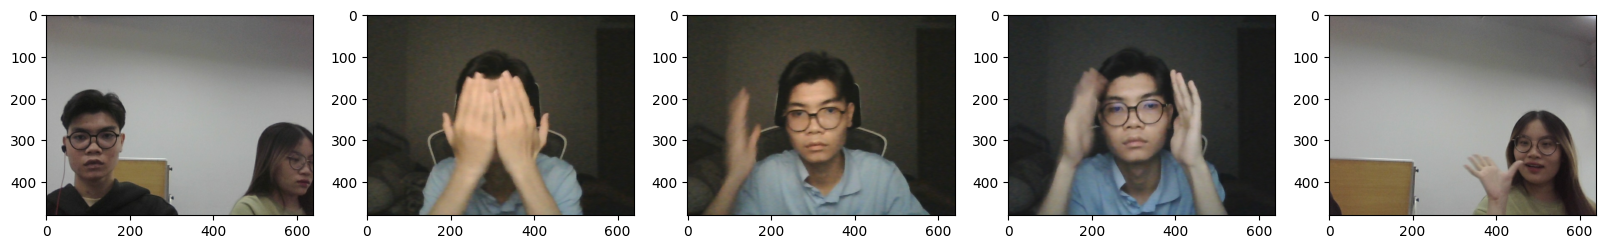

In [19]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [19]:
90*.7 # 63 to train

62.99999999999999

In [20]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [21]:
#os.listdir((os.path.join('data', 'train', 'images')))

In [20]:
# Lặp qua từng folder -> images -> images lấy từng labels tương ứng và chuyên vị trí của chúng đến các thư mục chỉ định
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [21]:
import albumentations as alb

In [22]:
augmentor = alb.Compose([
                         # Random Crop dùng để cắt hình ảnh theo width và height
                         alb.RandomCrop(width=450, height=450), 
                         # Random Horizontal Flip sẽ thay đổi hình ảnh theo chiều ngang
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [1]:
img = cv2.imread(os.path.join('data','train', 'images','2a0d9fdb-b3a2-11ee-9099-2cf05dff1d7f.jpg'))

NameError: name 'cv2' is not defined

In [24]:
img.shape

(480, 640, 3)

In [25]:
with open(os.path.join('data', 'train', 'labels', '2a0d9fdb-b3a2-11ee-9099-2cf05dff1d7f.json'), 'r') as f:
    label = json.load(f)

In [26]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[293.5294117647059, 187.59358288770053],
    [376.951871657754, 285.9893048128342]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\2a0d9fdb-b3a2-11ee-9099-2cf05dff1d7f.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnL

In [27]:
label['shapes'][0]['points']

[[293.5294117647059, 187.59358288770053],
 [376.951871657754, 285.9893048128342]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [28]:
# Làm phẳng lại ma trận
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [29]:
coords

[293.5294117647059, 187.59358288770053, 376.951871657754, 285.9893048128342]

In [30]:
coords = list(np.divide(coords, [640,480,640,480]))

In [31]:
coords

[0.458639705882353, 0.3908199643493761, 0.5889872994652406, 0.5958110516934045]

### 4.4 Apply Augmentations and View Results

In [32]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [34]:
augmented['bboxes'][0]

(0.1734402852049911,
 0.4200237670825907,
 0.35882352941176465,
 0.638680926916221)

In [35]:
augmented['image'].shape

(450, 450, 3)

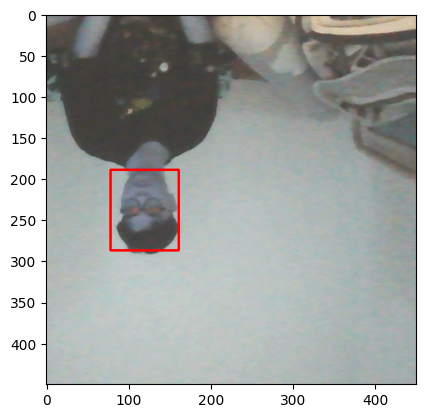

In [36]:
# Vẽ một ô hình chữ nhật trong hình theo tọa độ của bboxes
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [37]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        #  Coordiantes of bounding box for images are not have annotations
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        
        # Check whether label exists or not
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.5572359625668449, 0.6336898395721924, 0.44192847593582896, 0.43315508021390375, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [39]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [40]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [41]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [42]:
train_images.as_numpy_iterator().next()

array([[[0.17591912, 0.1764706 , 0.17941177],
        [0.16433823, 0.16862746, 0.18449755],
        [0.16194853, 0.17843138, 0.19283088],
        ...,
        [0.4790441 , 0.52616423, 0.5242034 ],
        [0.43033087, 0.47493872, 0.4871936 ],
        [0.41127452, 0.4499387 , 0.47843137]],

       [[0.18265931, 0.18412991, 0.19491422],
        [0.15980393, 0.19068627, 0.20392157],
        [0.15196079, 0.18039216, 0.21813725],
        ...,
        [0.49307597, 0.5476103 , 0.5539216 ],
        [0.48762256, 0.5430147 , 0.55490196],
        [0.49191177, 0.5377451 , 0.54148287]],

       [[0.1889093 , 0.19068627, 0.20147058],
        [0.1622549 , 0.18474264, 0.19552696],
        [0.14460784, 0.17996323, 0.17879902],
        ...,
        [0.4862745 , 0.5377451 , 0.57303923],
        [0.4853554 , 0.54025733, 0.57555145],
        [0.49626225, 0.5423407 , 0.5681985 ]],

       ...,

       [[0.49019608, 0.5210784 , 0.51862746],
        [0.5099265 , 0.52542895, 0.5294118 ],
        [0.5224265 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [43]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [44]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [47]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.05032, 0.5293 , 0.3867 , 0.933  ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [48]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8100, 8100, 2220, 2220, 2220, 2220)

### 7.2 Create Final Datasets (Images/Labels)

In [49]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(10000)
train = train.batch(8)
train = train.prefetch(4)

In [50]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(3000)
test = test.batch(8)
test = test.prefetch(4)

In [51]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(3000)
val = val.batch(8)
val = val.prefetch(4)

### 7.3 View Images and Annotations

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


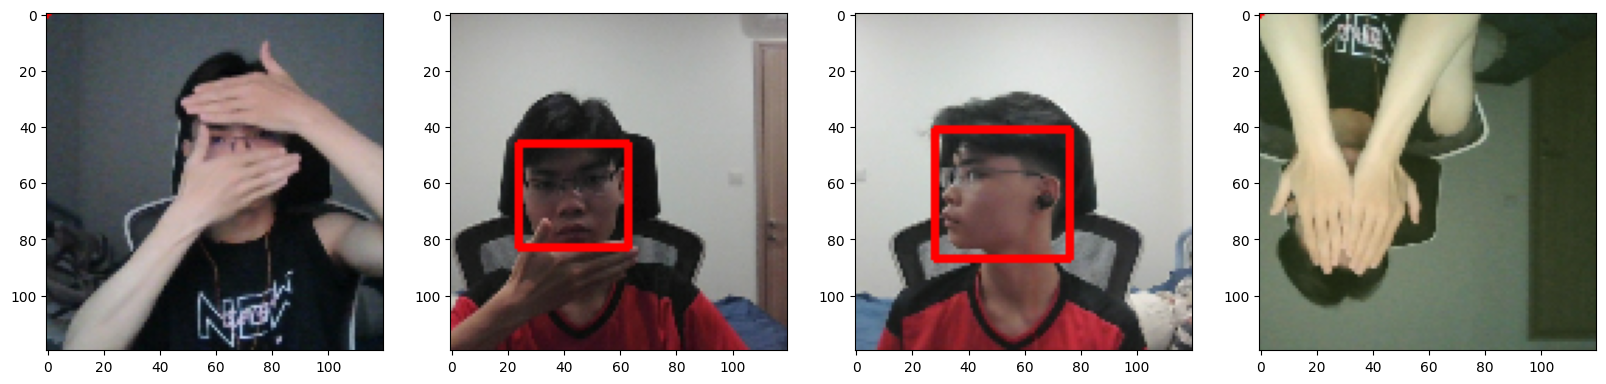

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    sample_image = np.array(sample_image)
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

 # 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [56]:
# VGG16 Architecture (Pre-trained on ImageNet)
vgg = VGG16(include_top=False)

In [57]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [58]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    print(input_layer)
    vgg = VGG16(include_top=False)(input_layer)
    

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1) # lấy dương còn âm bỏ đi
    class2 = Dense(1, activation='sigmoid')(class1) # chuyển giá trị về trong khoảng 0 - 1
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [59]:
build_model()

KerasTensor(type_spec=TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


### 8.4 Test out Neural Network

In [60]:
facetracker = build_model()

KerasTensor(type_spec=TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [61]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [62]:
X, y = train.as_numpy_iterator().next()

In [92]:
X

array([[[[0.45533088, 0.12493873, 0.1538603 ],
         [0.45232844, 0.10379902, 0.13762255],
         [0.44166666, 0.08743872, 0.12273284],
         ...,
         [0.15618873, 0.11715686, 0.13872549],
         [0.15520833, 0.13351716, 0.15441176],
         [0.15012255, 0.13057598, 0.13982843]],

        [[0.42922795, 0.10667892, 0.14148284],
         [0.41329658, 0.08768383, 0.11813726],
         [0.4788603 , 0.09895834, 0.1420956 ],
         ...,
         [0.1783701 , 0.13964461, 0.15042892],
         [0.1853554 , 0.11035539, 0.13235295],
         [0.23057598, 0.14387254, 0.14583333]],

        [[0.43033087, 0.08933824, 0.1314951 ],
         [0.45416668, 0.11280637, 0.14767157],
         [0.5057598 , 0.10692402, 0.15735294],
         ...,
         [0.28357843, 0.14362745, 0.15919118],
         [0.31942403, 0.16862746, 0.18082108],
         [0.32555148, 0.16740195, 0.17071079]],

        ...,

        [[0.62714463, 0.6193015 , 0.62322307],
         [0.6230392 , 0.6073529 , 0.60343134]

In [64]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 11s 11s/step


In [65]:
print("Classes: ", classes)
print("Coords: ", coords)

Classes:  [[0.5435785 ]
 [0.53750545]
 [0.5444941 ]
 [0.5128108 ]
 [0.5673035 ]
 [0.4790374 ]
 [0.53908646]
 [0.4566747 ]]
Coords:  [[0.24984854 0.33084333 0.54114765 0.34561476]
 [0.36211368 0.3553742  0.46117586 0.4365636 ]
 [0.29996368 0.42460284 0.43559945 0.2780162 ]
 [0.37204406 0.32308257 0.45336378 0.37036085]
 [0.35667065 0.29842648 0.42405325 0.3744933 ]
 [0.34332076 0.30240086 0.44527894 0.3585002 ]
 [0.28491706 0.31918952 0.45856437 0.3377804 ]
 [0.23174481 0.27567086 0.4244385  0.2858298 ]]


# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [66]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [67]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [68]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [69]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [70]:
localization_loss(y[1], coords).numpy()

1.5666023

In [71]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.65145797>

In [72]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.5666023>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [73]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [74]:
model = FaceTracker(facetracker)

In [75]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [76]:
logdir='logs'

In [77]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [78]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15


1013/1013 [==============================] - 113s 77ms/step - total_loss: 0.3646 - class_loss: 0.1345 - regress_loss: 0.2974 - val_total_loss: 0.0969 - val_class_loss: 0.0495 - val_regress_loss: 0.0721
Epoch 2/15
1013/1013 [==============================] - 83s 75ms/step - total_loss: 0.0886 - class_loss: 0.0308 - regress_loss: 0.0732 - val_total_loss: 0.0163 - val_class_loss: 4.4199e-05 - val_regress_loss: 0.0163
Epoch 3/15
1013/1013 [==============================] - 82s 75ms/step - total_loss: 0.0431 - class_loss: 0.0110 - regress_loss: 0.0376 - val_total_loss: 0.0070 - val_class_loss: 3.6342e-04 - val_regress_loss: 0.0068
Epoch 4/15
1013/1013 [==============================] - 91s 81ms/step - total_loss: 0.0411 - class_loss: 0.0152 - regress_loss: 0.0335 - val_total_loss: 0.0040 - val_class_loss: 2.8055e-04 - val_regress_loss: 0.0039
Epoch 5/15
1013/1013 [==============================] - 84s 75ms/step - total_loss: 0.0232 - class_loss: 0.0064 - regress_loss: 0.0200 - val_total_los

### 10.3 Plot Performance

In [79]:
hist.history

{'total_loss': [0.0160154290497303,
  0.008721211925148964,
  0.007086317054927349,
  0.001344901043921709,
  0.0008168589556589723,
  0.0036472545471042395,
  0.004737946670502424,
  0.0018410581396892667,
  0.0006012020749039948,
  0.0012332318583503366,
  0.0022967634722590446,
  0.002299539279192686,
  0.0016877033049240708,
  0.0011367362458258867,
  0.0021571426186710596],
 'class_loss': [0.0003452542005106807,
  2.8402402676874772e-05,
  0.00023717015574220568,
  3.080174792557955e-05,
  6.486944039352238e-05,
  2.065332591882907e-05,
  5.917910311836749e-05,
  1.5765635907882825e-05,
  8.798543422017246e-05,
  5.02216316817794e-05,
  0.00024926368496380746,
  0.0005415631458163261,
  1.6927911929087713e-05,
  5.096220320410794e-06,
  1.7881859093904495e-05],
 'regress_loss': [0.015842802822589874,
  0.008707011118531227,
  0.00696773175150156,
  0.0013295002281665802,
  0.0007844242500141263,
  0.0036369278095662594,
  0.0047083571553230286,
  0.0018331753090023994,
  0.0005572

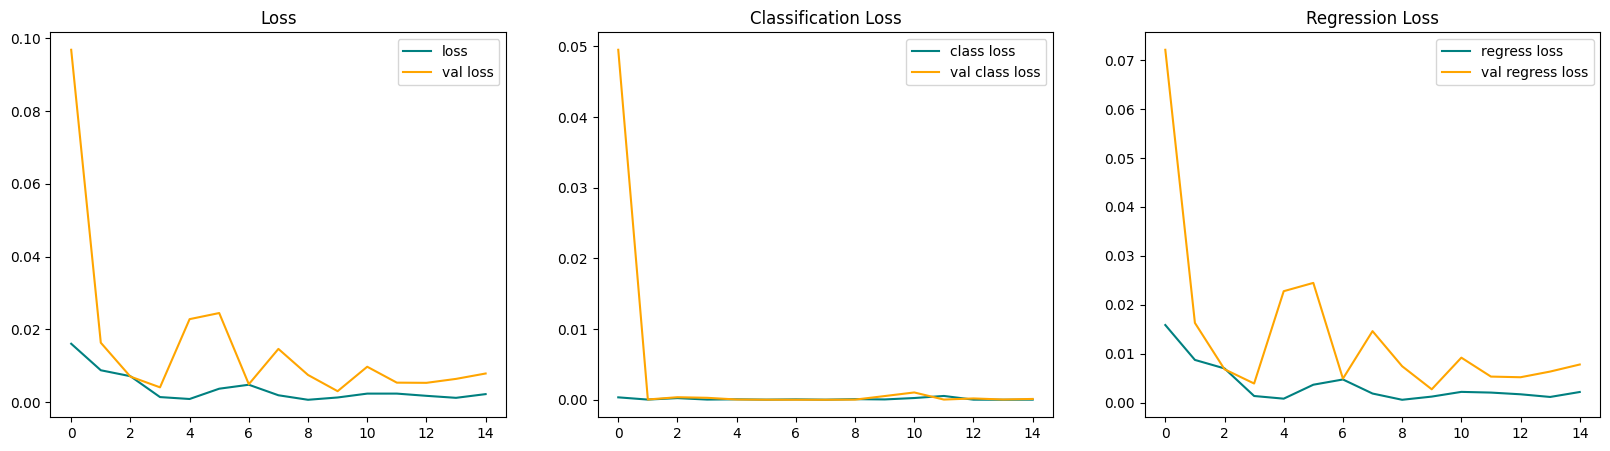

In [80]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [81]:
test_data = test.as_numpy_iterator()

In [1]:
test_sample = test_data.next()

NameError: name 'test_data' is not defined

In [2]:
test_sample[0]

NameError: name 'test_sample' is not defined

In [84]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


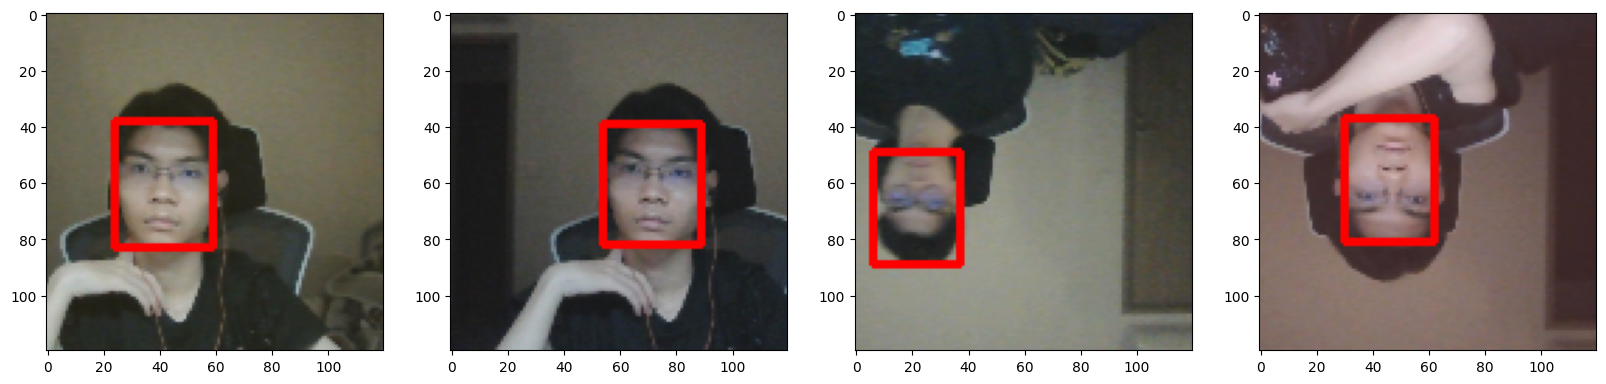

In [85]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    sample_image = np.array(sample_image)
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [86]:
from tensorflow.keras.models import load_model

In [87]:
facetracker.save('facetracker.h5')

In [88]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [89]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.9: 
        # Tạo khung khoanh vùng nhận diện khuôn mặt
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        
        # Khung hiển thị class
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [70,0])), 
                            (255,0,0), -1)
        
        # Cài đặt vị trí đặt tên class
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()# Giải phóng window
cv2.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step


In [90]:
cap.release()# Giải phóng window
cv2.destroyAllWindows()